In [1]:
import os
import glob
import subprocess
import numpy as np
import pandas as pd
import scipy.io
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
# Statistical Analysis
from scipy.stats import skew, kurtosis
from scipy.stats import zscore
from scipy.stats import probplot

In [3]:
# Scikit-learn Modules
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import OPTICS
from sklearn.svm import SVC
from sklearn.utils import class_weight

In [4]:
from imblearn.over_sampling import SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [5]:
# TensorFlow / Keras for Deep Learning
import tensorflow as tf
from tensorflow.keras import Model, callbacks, layers
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

/Users/saikiran/Downloads/BEARING/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [6]:
# Paths to the .mat files
baseline_file = '/Users/saikiran/Downloads/inner_race_fault.mat'
inner_race_file = '/Users/saikiran/Downloads/baseline.mat'

# Load the .mat files and print their keys
baseline_data = scipy.io.loadmat(baseline_file)
inner_race_data = scipy.io.loadmat(inner_race_file)

# Print the keys in both files
print(f"Keys in baseline file: {list(baseline_data.keys())}")
print(f"Keys in inner race fault file: {list(inner_race_data.keys())}")


Keys in baseline file: ['__header__', '__version__', '__globals__', 'X059_DE_time']
Keys in inner race fault file: ['__header__', '__version__', '__globals__', 'X100_DE_time', 'X100_FE_time', 'X100RPM']


In [7]:
# Extract signals using the correct keys
baseline_signal = baseline_data['X059_DE_time'].flatten()  # Baseline signal
inner_race_signal = inner_race_data['X100_DE_time'].flatten()  # Inner race fault signal


In [8]:
 #given Sampling frequency
freq_sample = 12000  # 12 kHz

# BPFI calculations
rotation_frequency = 1725 / 60  # Convert RPM to Hz
bpfi_multiplier = 5.4152
freq_bpfi = rotation_frequency * bpfi_multiplier
freq_bpfi_harmonics = freq_bpfi * (1 + np.arange(20))  # Compute first 20 harmonics

# print frequency and harmonics
print(f"BPFI first frequency: {freq_bpfi:.2f} Hz")
print("Expected BPFI harmonic frequencies: " + np.array2string(freq_bpfi_harmonics, precision=2, separator=', ') + " Hz")

BPFI first frequency: 155.69 Hz
Expected BPFI harmonic frequencies: [ 155.69,  311.37,  467.06,  622.75,  778.43,  934.12, 1089.81, 1245.5 ,
 1401.18, 1556.87, 1712.56, 1868.24, 2023.93, 2179.62, 2335.3 , 2490.99,
 2646.68, 2802.37, 2958.05, 3113.74] Hz


In [9]:
def compute_fft(signal, sampling_rate):
    window = np.hanning(len(signal))  # Apply Hanning window to reduce spectral leakage
    signal_windowed = window * signal  # Multiply signal by window function
    fft_result = np.fft.fft(signal_windowed)  # Compute FFT
    amplitude = 2 * np.abs(fft_result[:len(signal)//2]) / len(signal)  # Compute amplitude spectrum
    freq_axis = np.linspace(0, sampling_rate / 2, len(amplitude))  # Generate frequency axis
    return freq_axis, amplitude

In [10]:
# Function to Plot FFT
def plot_fft(freq_axis, amplitude, title, f_bpfi, f_bpfi_harmonics):
    plt.figure(figsize=(10, 5))
    plt.plot(freq_axis, amplitude, label=title, color='b')
    plt.axvline(f_bpfi, color='r', linestyle='--', label=f'BPFI: {f_bpfi:.2f} Hz')
    plt.axvline(f_bpfi_harmonics[0], color='g', linestyle='--', label=f'Harmonic 1: {f_bpfi_harmonics[0]:.2f} Hz')
    plt.title(f'FFT of {title}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()

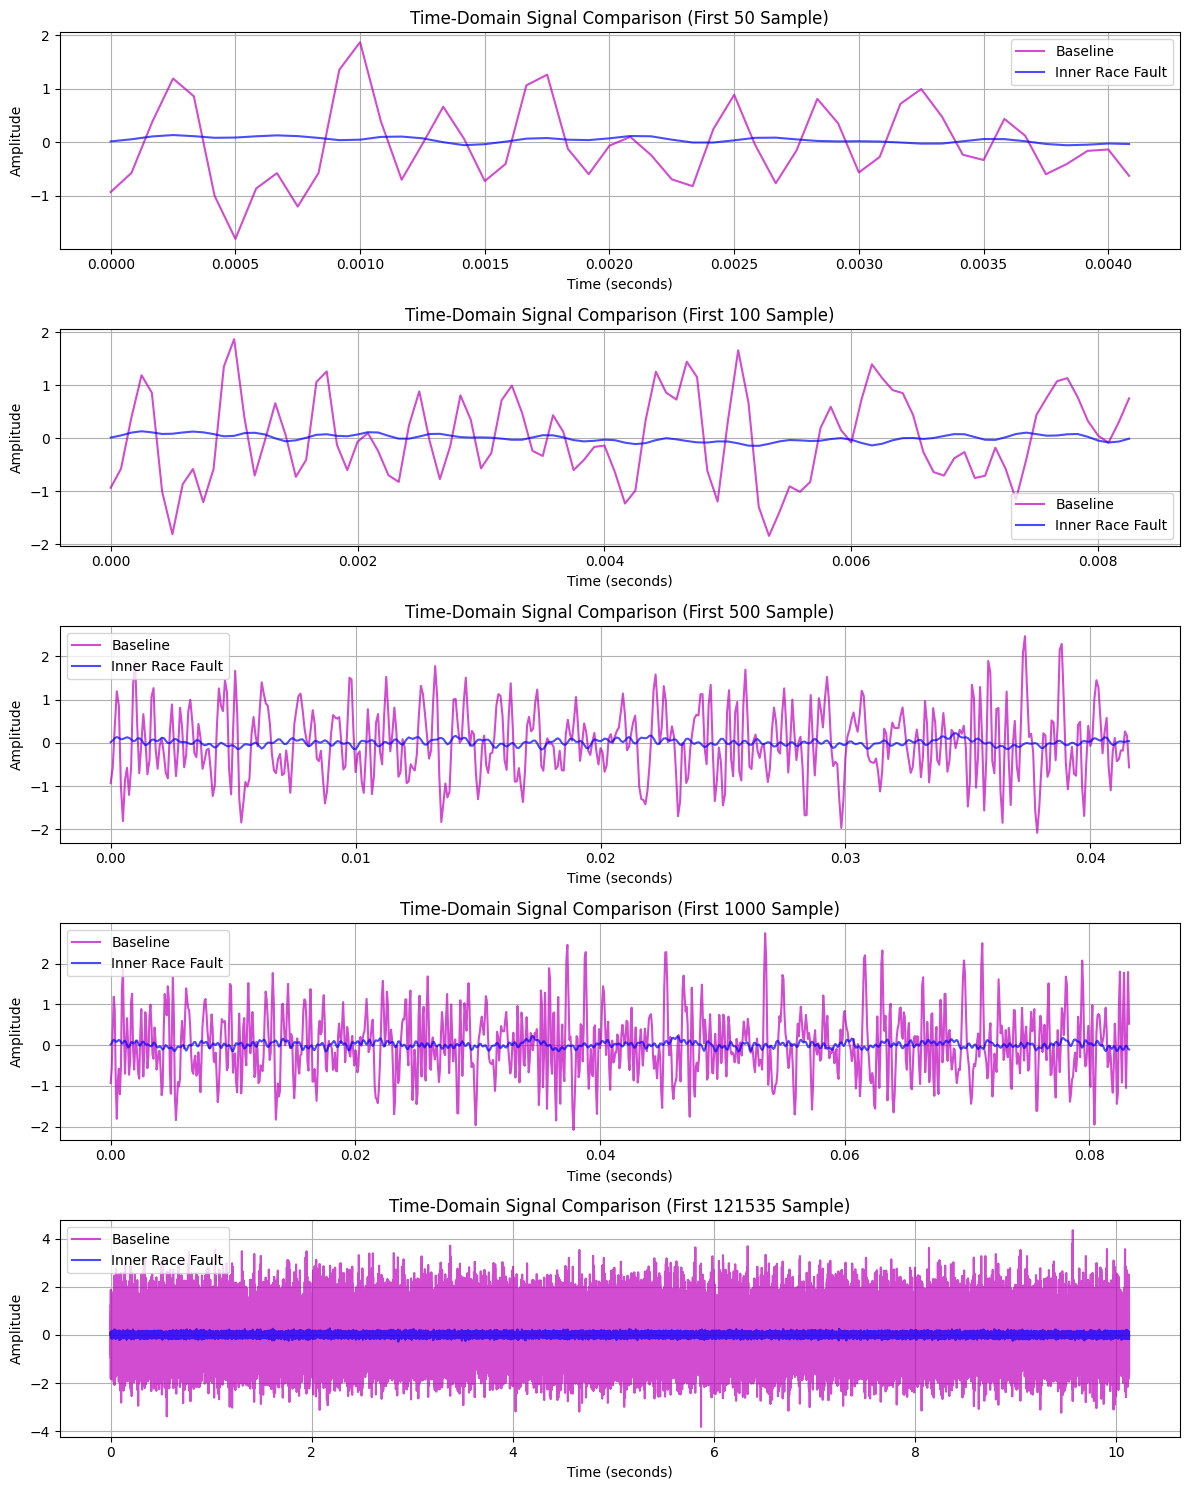

In [11]:

# Time axis (for full signal)
time_baseline = np.arange(len(baseline_signal)) / freq_sample
time_inner_race = np.arange(len(inner_race_signal)) / freq_sample

# Sample sizes to plot
sample_sizes = [50, 100, 500, 1000, min(len(baseline_signal), len(inner_race_signal))]

# Create subplots
fig, axes = plt.subplots(len(sample_sizes), 1, figsize=(12, 15))

for i, sample_size in enumerate(sample_sizes):
    # Define time axes for selected samples
    time_baseline_sample = time_baseline[:sample_size]
    time_inner_race_sample = time_inner_race[:sample_size]

    # Plot baseline signal
    axes[i].plot(time_baseline_sample, baseline_signal[:sample_size], label="Baseline", color="m", alpha=0.7)

    # Plot inner race fault signal
    axes[i].plot(time_inner_race_sample, inner_race_signal[:sample_size], label="Inner Race Fault", color="b", alpha=0.7)

    # Labels and formatting
    axes[i].set_title(f"Time-Domain Signal Comparison (First {sample_size} Sample)")
    axes[i].set_xlabel("Time (seconds)")
    axes[i].set_ylabel("Amplitude")
    axes[i].legend()
    axes[i].grid(True)

# plot
plt.tight_layout()
plt.show()


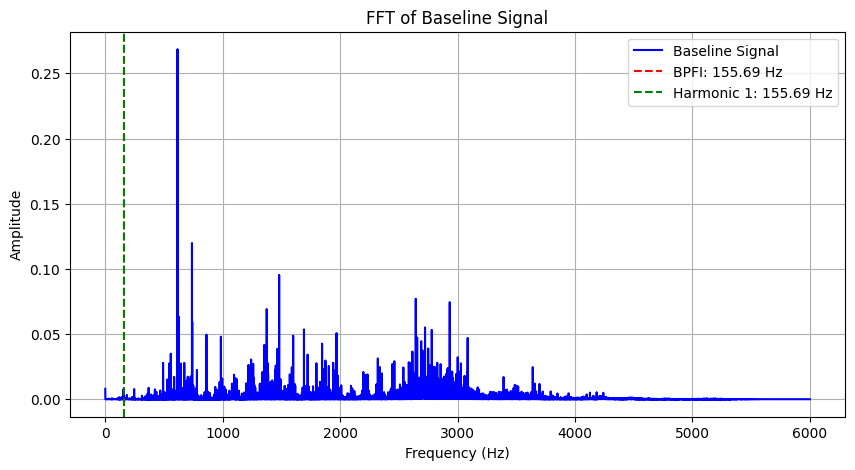

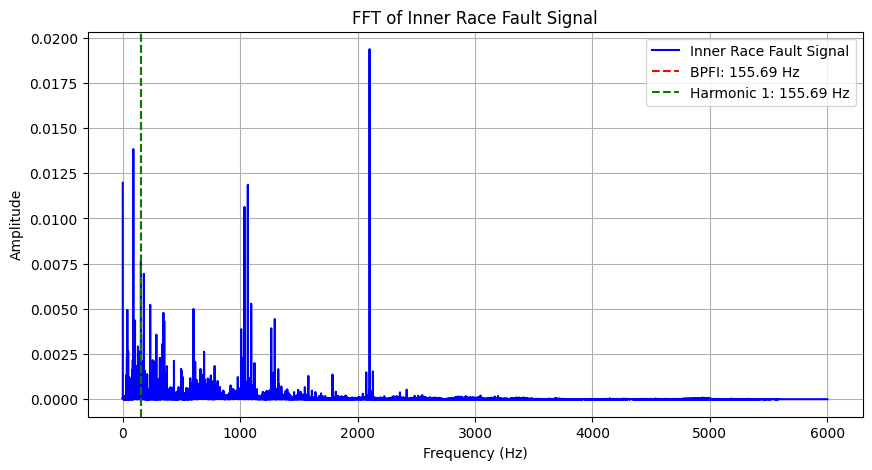

In [12]:
# FREQUENCY DOMAINfor both signals
freq_axis_baseline, amplitude_baseline = compute_fft(baseline_signal, freq_sample)
freq_axis_fault, amplitude_fault = compute_fft(inner_race_signal, freq_sample)

# Plot
plot_fft(freq_axis_baseline, amplitude_baseline, 'Baseline Signal', freq_bpfi, freq_bpfi_harmonics)
plot_fft(freq_axis_fault, amplitude_fault, 'Inner Race Fault Signal', freq_bpfi, freq_bpfi_harmonics)

In [13]:
print(f"Baseline Signal Shape: {baseline_signal.shape}")
print(f"Inner Race Signal Shape: {inner_race_signal.shape}")


Baseline Signal Shape: (121535,)
Inner Race Signal Shape: (485643,)


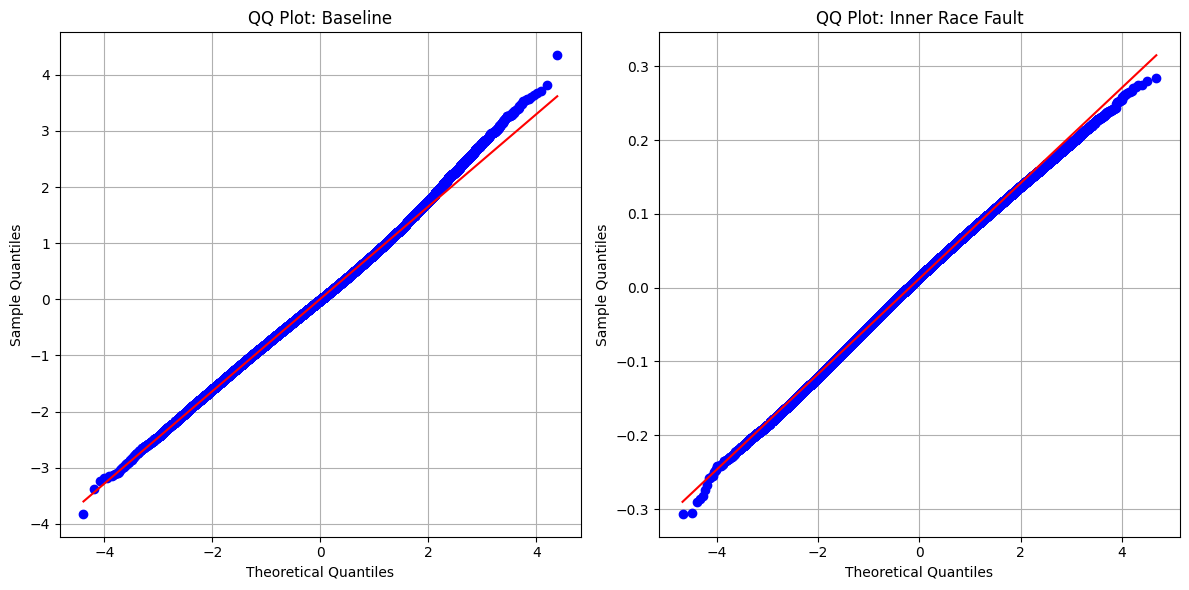

In [14]:
# QQ Plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Baseline Signal QQ Plot
probplot(baseline_signal, dist='norm', plot=axes[0])
axes[0].set_title('QQ Plot: Baseline')
axes[0].grid(True)
axes[0].set_xlabel("Theoretical Quantiles")
axes[0].set_ylabel("Sample Quantiles")

# Inner Race Fault Signal QQ Plot
probplot(inner_race_signal, dist='norm', plot=axes[1])
axes[1].set_title('QQ Plot: Inner Race Fault')
axes[1].grid(True)
axes[1].set_xlabel("Theoretical Quantiles")
axes[1].set_ylabel("Sample Quantiles")

# plot
plt.tight_layout()
plt.show()



In [15]:
# Statistics
print(f'Mean Baseline: {baseline_signal.mean():.3f}, STD Baseline: {baseline_signal.std():.3f}')
print(f'Mean Faulty: {inner_race_signal.mean():.3f}, STD Faulty: {inner_race_signal.std():.3f}')

Mean Baseline: 0.008, STD Baseline: 0.823
Mean Faulty: 0.012, STD Faulty: 0.065


In [16]:
# Standardize signals
baseline_signal_std = (baseline_signal - np.mean(baseline_signal)) / np.std(baseline_signal)
inner_race_signal_std = (inner_race_signal - np.mean(inner_race_signal)) / np.std(inner_race_signal)

# Time axis
freq_sample = 12000
time_baseline = np.arange(len(baseline_signal)) / freq_sample
time_inner = np.arange(len(inner_race_signal)) / freq_sample

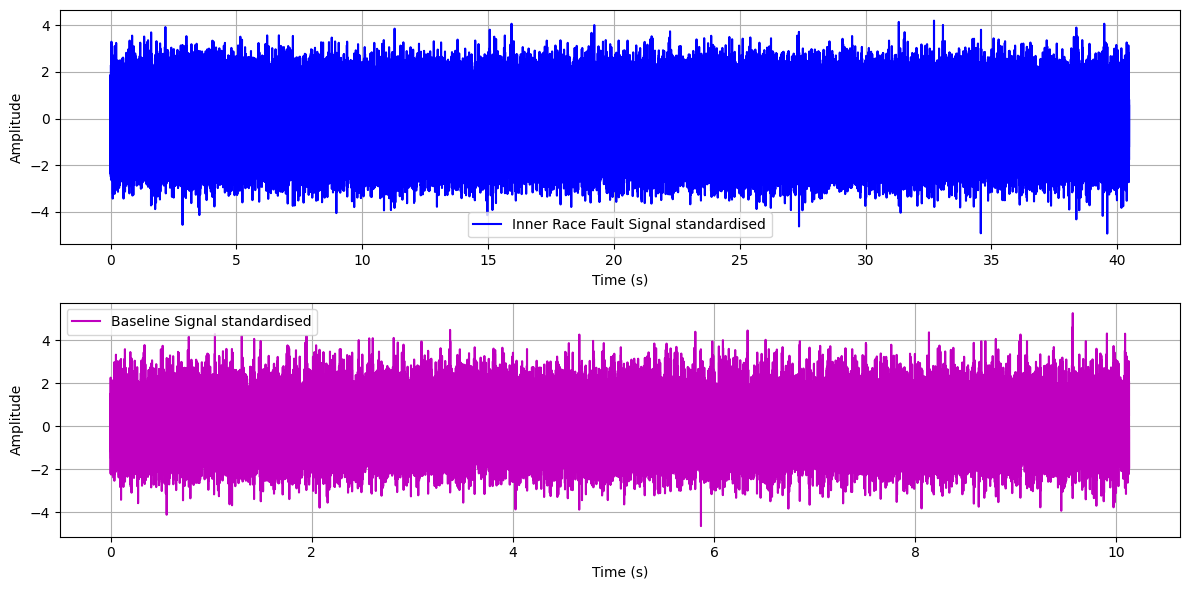

In [17]:
# Plot signals
plt.figure(figsize=(12, 6))
for i, (signal, time, title, color) in enumerate([
    (inner_race_signal_std, time_inner, "Inner Race Fault Signal standardised", "b"),
    (baseline_signal_std, time_baseline, "Baseline Signal standardised", "m")
]):
    plt.subplot(2, 1, i + 1)
    plt.plot(time, signal, color, label=title)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()

In [18]:

#  mean and std
print(f'Mean (Inner Race Fault): {inner_race_signal.mean():.3f}, STD: {inner_race_signal.std():.3f}')
print(f'Mean (Baseline): {baseline_signal.mean():.3f}, STD: {baseline_signal.std():.3f}')

Mean (Inner Race Fault): 0.012, STD: 0.065
Mean (Baseline): 0.008, STD: 0.823


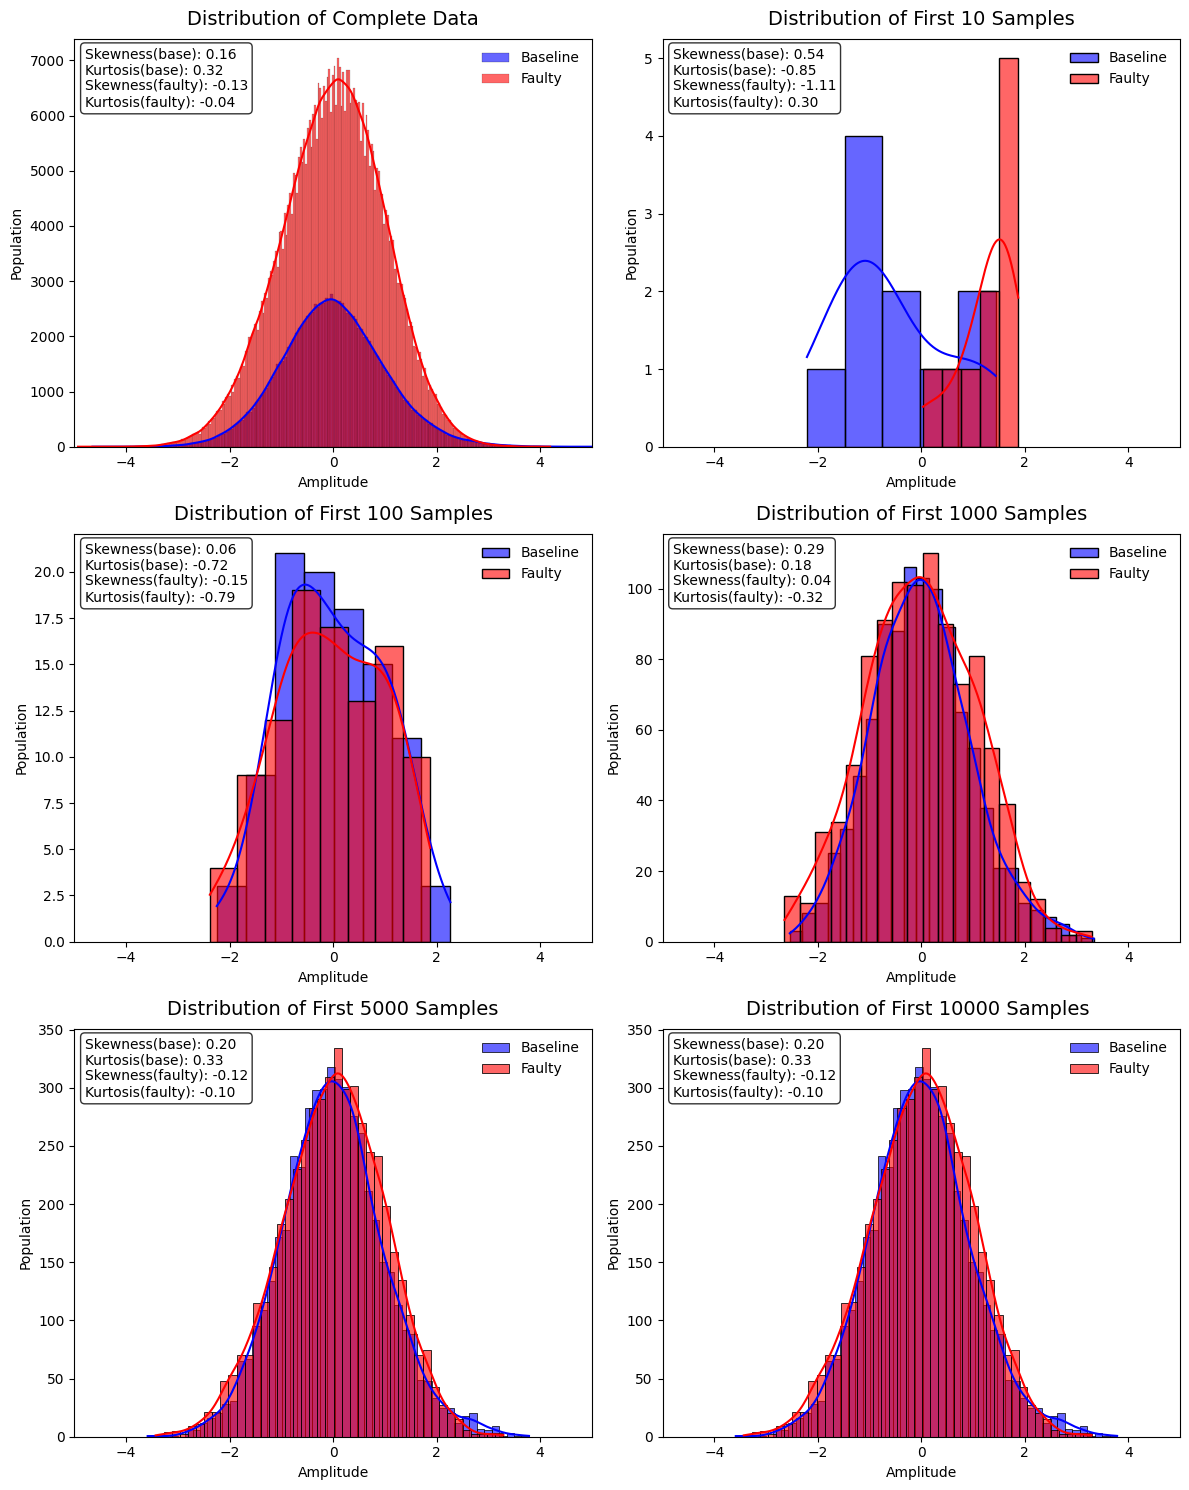

In [19]:
from scipy import stats
# Distribution Analysis
fig, axes = plt.subplots(3, 2, figsize=(12, 15))  # Adjust the layout for 6 subplots
fig.subplots_adjust(hspace=0.5, wspace=0.3)

#  data slices for different plots
data_slices = [
    (baseline_signal_std, inner_race_signal_std, 'Complete Data'),
    (baseline_signal_std[:10], inner_race_signal_std[:10], 'First 10 Samples'),
    (baseline_signal_std[:100], inner_race_signal_std[:100], 'First 100 Samples'),
    (baseline_signal_std[:1000], inner_race_signal_std[:1000], 'First 1000 Samples'),
    (baseline_signal_std[:5000], inner_race_signal_std[:5000], 'First 5000 Samples'),
    (baseline_signal_std[:5000], inner_race_signal_std[:5000], 'First 10000 Samples ')
]
# Loop through data slices and plots
for i, (baseline_data, fault_data, title) in enumerate(data_slices):
    ax = axes[i // 2, i % 2]
    
    sns.histplot(baseline_data, kde=True, ax=ax, label='Baseline', color='blue', alpha=0.6)
    sns.histplot(fault_data, kde=True, ax=ax, label='Faulty', color='red', alpha=0.6)
    
    ax.set_xlim([-5, 5])
    ax.set_ylabel('Population')
    ax.set_xlabel('Amplitude')
    ax.set_title(f'Distribution of {title}', size=14, pad=10)
    
    annotation_text = (
        f'Skewness(base): {stats.skew(baseline_data):.2f}\n'
        f'Kurtosis(base): {stats.kurtosis(baseline_data):.2f}\n'
        f'Skewness(faulty): {stats.skew(fault_data):.2f}\n'
        f'Kurtosis(faulty): {stats.kurtosis(fault_data):.2f}'
    )
    
    ax.annotate(annotation_text, xy=(0.02, 0.98), xycoords='axes fraction',
                fontsize=10, color='black',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                verticalalignment='top')
    
    ax.legend(loc='upper right', frameon=False)

plt.tight_layout()
plt.show()

In [20]:
# Ensure both signals have the same length
min_length = min(len(time), len(inner_race_signal_std))
time = time[:min_length]
inner_race_signal_std = inner_race_signal_std[:min_length]

In [21]:
# Ensure both signals have the same length
min_length = min(len(baseline_signal_std), len(inner_race_signal_std))
baseline_signal_std = baseline_signal_std[:min_length]
inner_race_signal_std = inner_race_signal_std[:min_length]


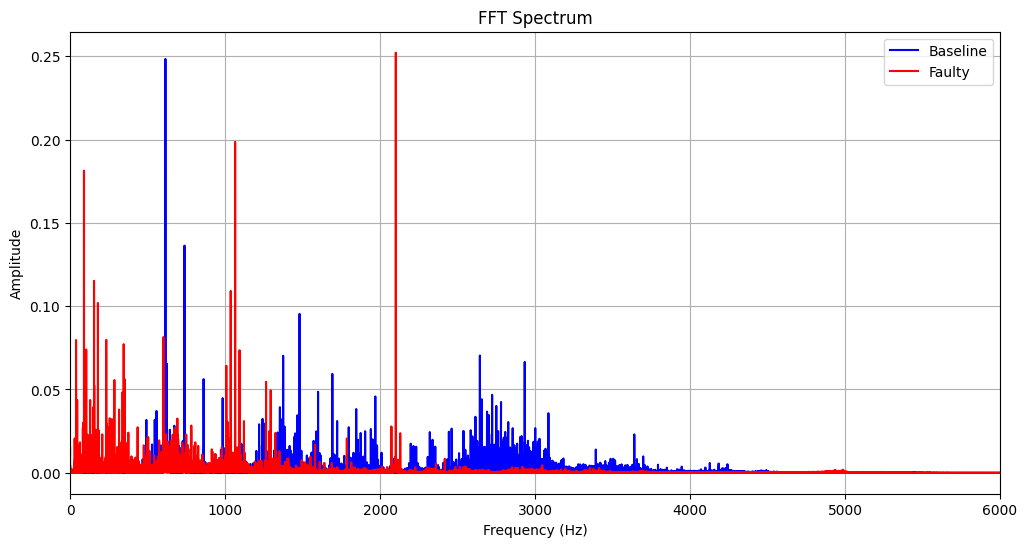

In [22]:
# FFT parameters
N = min_length
freqs = np.fft.rfftfreq(N, d=1/freq_sample)
fft_baseline = np.abs(np.fft.rfft(baseline_signal_std)) / N
fft_fault = np.abs(np.fft.rfft(inner_race_signal_std)) / N

# Plot FFT
plt.figure(figsize=(12, 6))
plt.plot(freqs, fft_baseline, label='Baseline', color='blue')
plt.plot(freqs, fft_fault, label='Faulty', color='red')
plt.xlim([0, 6000])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('FFT Spectrum')
plt.legend()
plt.grid()
plt.show()


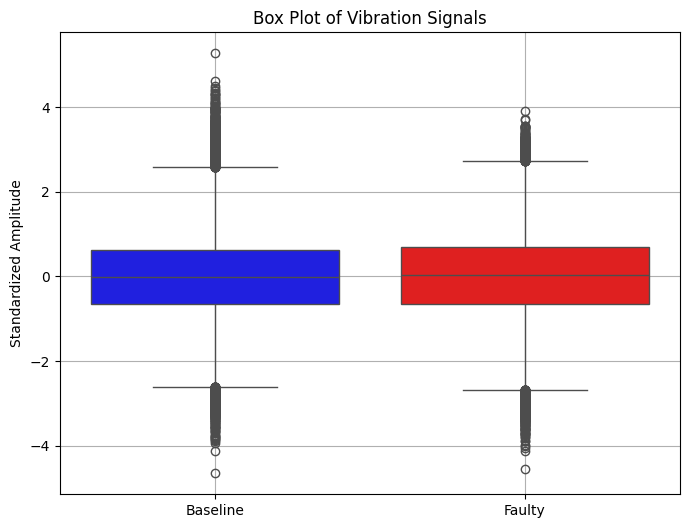

In [32]:
# Create box plot
df = pd.DataFrame({
    'Baseline': baseline_signal_std,
    'Faulty': inner_race_signal_std
})

plt.figure(figsize=(8, 6))
sns.boxplot(data=df, palette=['blue', 'red'])
plt.ylabel('Standardized Amplitude')
plt.title('Box Plot of Vibration Signals')
plt.grid(True)
plt.show()

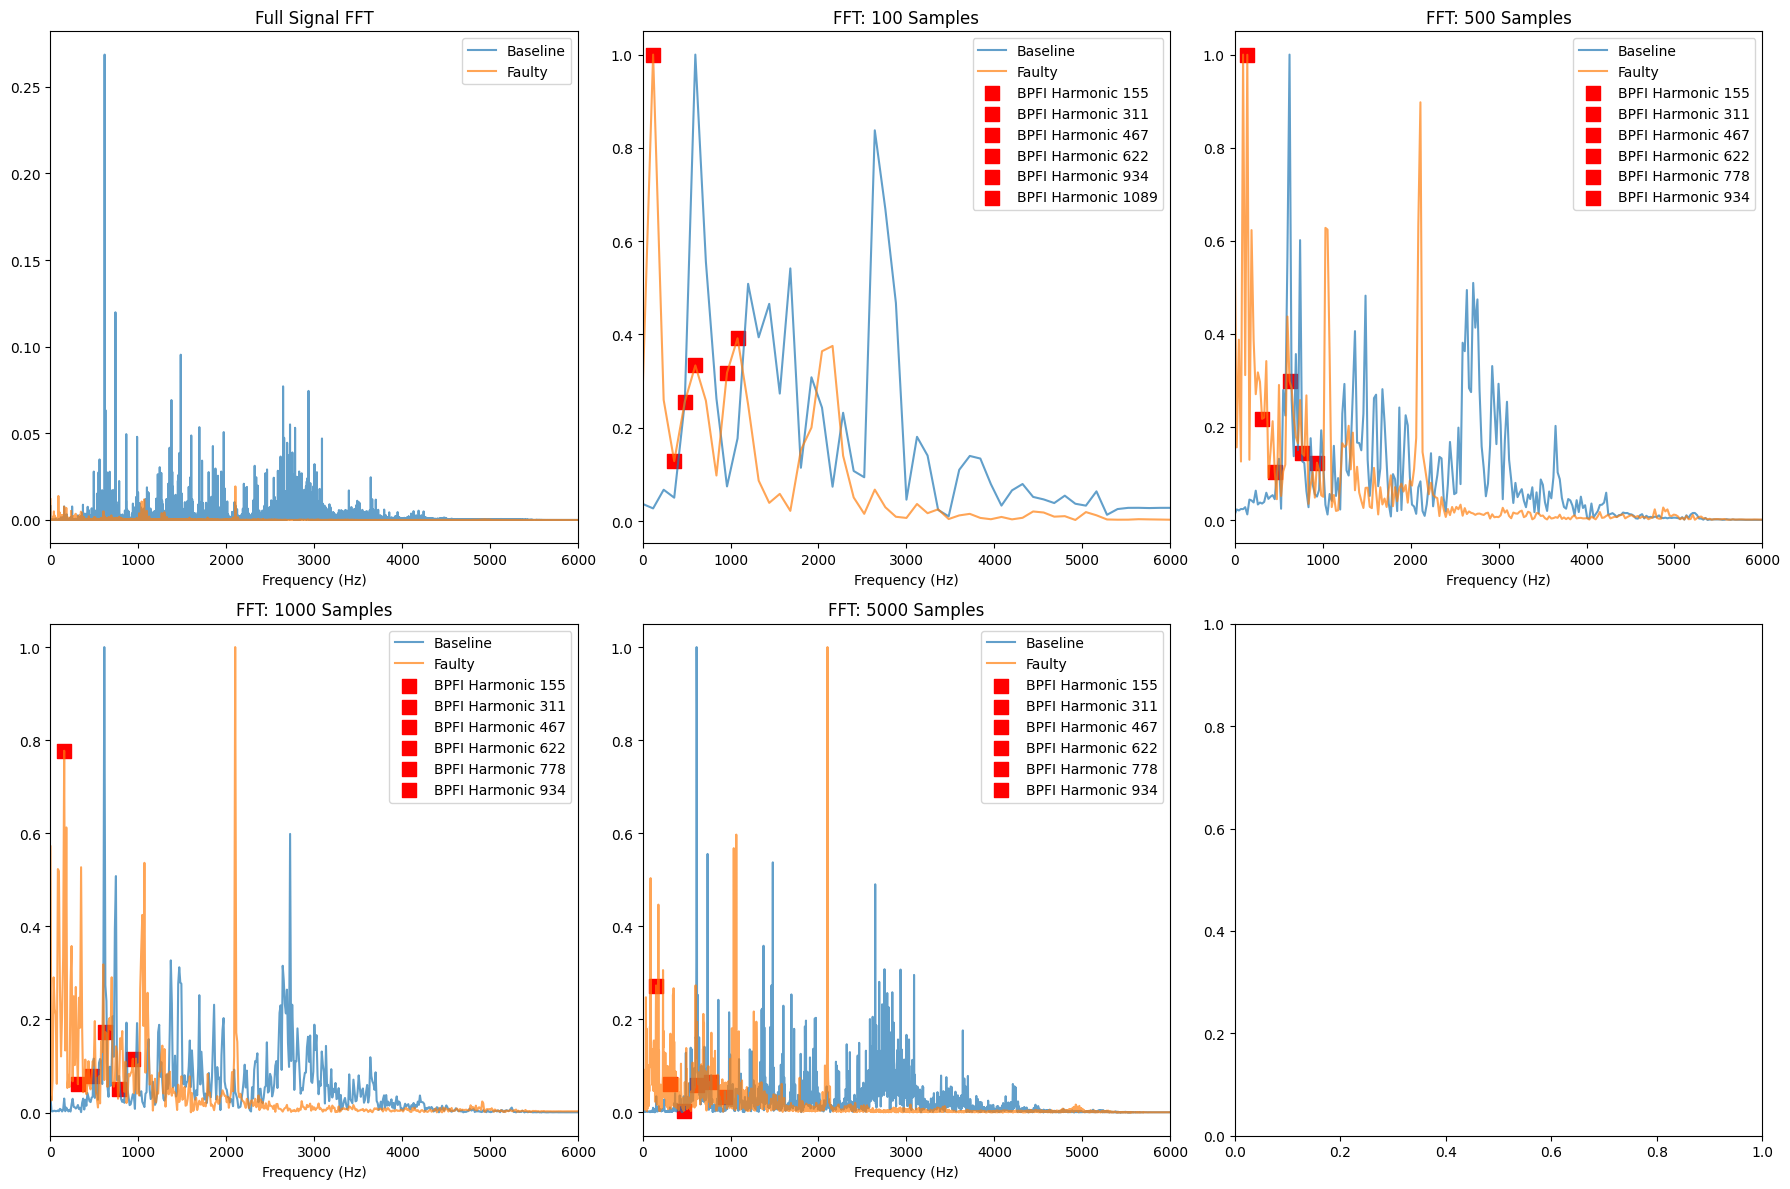

In [24]:

# FREQUENCY DOMAIN OVERLAP TO VISULISE AND COMAPRE 
freq_baseline, fft_baseline = compute_fft(baseline_signal, freq_sample)
freq_fault, fft_fault = compute_fft(inner_race_signal, freq_sample)

# subset lengths for faulty signal
subset_lengths = [100, 500, 1000, 5000]  # Four subsets

#  subplots (2x3 grid for 6 plots)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.subplots_adjust(hspace=0.5)

# Complete Signal FFT (first subplot)
axes[0, 0].plot(freq_baseline, fft_baseline, label='Baseline', alpha=0.7)
axes[0, 0].plot(freq_fault, fft_fault, label='Faulty', alpha=0.7)
axes[0, 0].set_xlim([0, 6000])
axes[0, 0].set_xlabel('Frequency (Hz)')
axes[0, 0].set_title('Full Signal FFT')
axes[0, 0].legend()

# Frequency domain plots for different subsets
for i, subset_length in enumerate(subset_lengths):  
    freq_subset = np.fft.rfftfreq(subset_length, d=1/freq_sample)
    
    # FFT for subset signals
    fft_baseline_subset = np.abs(np.fft.rfft(baseline_signal[:subset_length])) / np.max(np.abs(np.fft.rfft(baseline_signal[:subset_length])))
    fft_fault_subset = np.abs(np.fft.rfft(inner_race_signal[:subset_length])) / np.max(np.abs(np.fft.rfft(inner_race_signal[:subset_length])))
    
    row, col = divmod(i + 1, 3)  # Adjusting for 2x3 grid
    axes[row, col].plot(freq_subset, fft_baseline_subset, label='Baseline', alpha=0.7)
    axes[row, col].plot(freq_subset, fft_fault_subset, label='Faulty', alpha=0.7)
    
    # Highlight the first 6 matching harmonics
    matched_harmonics = 0
    for harmonic in freq_bpfi_harmonics:
        if harmonic < np.max(freq_subset):  # Check if harmonic is within range
            closest_peak_idx = np.argmin(np.abs(freq_subset - harmonic))  # Find closest peak
            closest_peak_freq = freq_subset[closest_peak_idx]
            
            # If the closest peak is close to the harmonic, mark it
            if np.abs(closest_peak_freq - harmonic) < 50:  # Tolerance in Hz
                axes[row, col].scatter(closest_peak_freq, fft_fault_subset[closest_peak_idx], 
                                       color='red', s=100, marker='s', label=f'BPFI Harmonic {int(harmonic)}')
                matched_harmonics += 1
                if matched_harmonics == 6:  # Stop after 6 harmonics
                    break

    axes[row, col].set_xlim([0, 6000])
    axes[row, col].set_xlabel('Frequency (Hz)')
    axes[row, col].set_title(f'FFT: {subset_length} Samples')
    axes[row, col].legend()

# Show the final plot
plt.tight_layout()
plt.show()


In [25]:
class BearingAnalyzer:
    def __init__(self, sampling_freq=12000):
        """Initialize the bearing analyzer with sampling frequency."""
        self.sampling_freq = sampling_freq
        self.baseline_signal = None
        self.fault_signal = None

    def load_mat_files(self, baseline_path, fault_path, baseline_key, fault_key):
        """Load vibration data from .mat files."""
        self.baseline_signal = scipy.io.loadmat(baseline_path)[baseline_key].flatten()
        self.fault_signal = scipy.io.loadmat(fault_path)[fault_key].flatten()

    def create_windows(self, signal, window_size=1000, stride=100):
        """Create overlapping windows from signal using NumPy vectorized slicing."""
        num_windows = (len(signal) - window_size) // stride + 1
        return np.lib.stride_tricks.sliding_window_view(signal, window_size)[::stride]

if __name__ == "__main__":
    analyzer = BearingAnalyzer()
    analyzer.load_mat_files(
        baseline_path='/Users/saikiran/Downloads/baseline.mat',
        fault_path='/Users/saikiran/Downloads/inner_race_fault.mat',
        baseline_key='X100_DE_time',
        fault_key='X059_DE_time'
    )
    # Create windows
    baseline_windows = analyzer.create_windows(analyzer.baseline_signal)
    fault_windows = analyzer.create_windows(analyzer.fault_signal)


In [26]:
class DimensionalityReducer:
    def __init__(self, baseline_windows, fault_windows):
        """Initialize with windowed signals."""
        self.baseline_windows = baseline_windows
        self.fault_windows = fault_windows

    def perform_dimensionality_reduction(self):
        """Perform PCA and t-SNE on standardized data."""
        X = np.vstack([self.baseline_windows, self.fault_windows])
        labels = np.array(['Baseline'] * len(self.baseline_windows) + ['Faulty'] * len(self.fault_windows))

        # Standardize data
        X_scaled = StandardScaler().fit_transform(X)

        # PCA
        X_pca = PCA(n_components=2).fit_transform(X_scaled)

        # t-SNE (handling errors)
        try:
            X_tsne = TSNE(n_components=2, perplexity=min(30, len(X) - 1), random_state=42).fit_transform(X_scaled)
        except Exception as e:
            print(f"t-SNE Error: {e}")
            X_tsne = np.zeros((len(X), 2))  # Placeholder

        return X_pca, X_tsne, labels

reducer = DimensionalityReducer(baseline_windows, fault_windows)
X_pca, X_tsne, labels = reducer.perform_dimensionality_reduction()


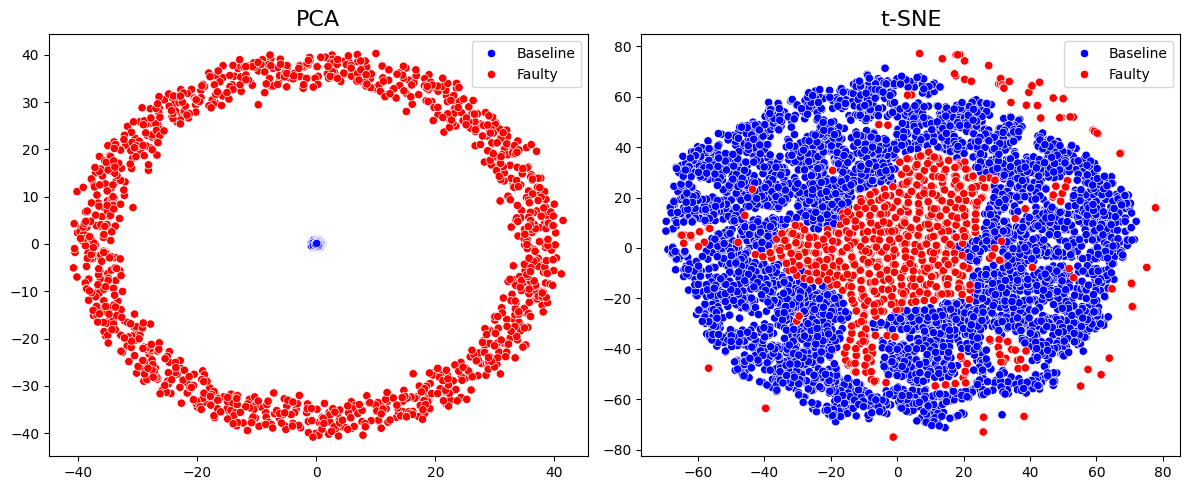

In [27]:
class DataVisualizer:
    @staticmethod
    def plot_dimensionality_reduction(X_pca, X_tsne, labels):
        """Plot PCA and t-SNE results."""
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        titles = ['PCA', 't-SNE']
        data = [X_pca, X_tsne]

        for ax, X, title in zip(axes, data, titles):
            sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, palette={'Baseline': 'b', 'Faulty': 'r'}, ax=ax)
            ax.set_title(title, size=16)
            ax.legend(loc='best')

        plt.tight_layout()
        return fig

# Example usage for Chunk 3
visualizer = DataVisualizer()
fig_dr = visualizer.plot_dimensionality_reduction(X_pca, X_tsne, labels)
plt.show()
